<a href="https://colab.research.google.com/github/jahantaila/9th-Science-Fair/blob/main/sciencefair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Science Fair Project - Jahan Bakhtyar Taila**
# ***A novel approach at detecting and classifying  Arrhythmia in ECG data by utilizing LSTM autoencoders and Time Series Data***

In [ ]:
# installs/imports


!pip install  torch
import torch


!pip install arff2pandas
from arff2pandas import a2p



import copy
import numpy as np
import pandas as pd
import seaborn as sns 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F


In [ ]:
# Get data from http://timeseriesclassification.com/description.php?Dataset=ECG5000

!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

#Unzip

!unzip -qq ECG5000.zip






Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 92.5MB/s]
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# start pytorch device


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# load arff data as pandas dataframe 
#converts the arff data into pandas dataframe using arff2pandas -0 
#takes training and testing data


with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)
with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)



In [ ]:
#combine and shuffle data


df = train.append(test)
df = df.sample(frac=1.0)
df.shape


 # df.sample(frac=9.2)



(5000, 141)

In [ ]:
# name the heartbeat classes

CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']
print(class_names)




['Normal', 'R on T', 'PVC', 'SP', 'UB']


In [ ]:
# rename last row to target
# make it easier to reference later on 
#--------------------------------------------------
#- Binary key:00001111010101011100001111000 
# mathplotlib? 
#try easy integer notaton
#possbile set notation?????? - might need to integrate linear/polynominal regression later
# depends on how the data curve turns out
#--------------------------------------------------------

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
#check how much training data in each heartbeat class

df.target.value_counts()




1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

Data Class #1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 0, 'Heartbeat Classes')]

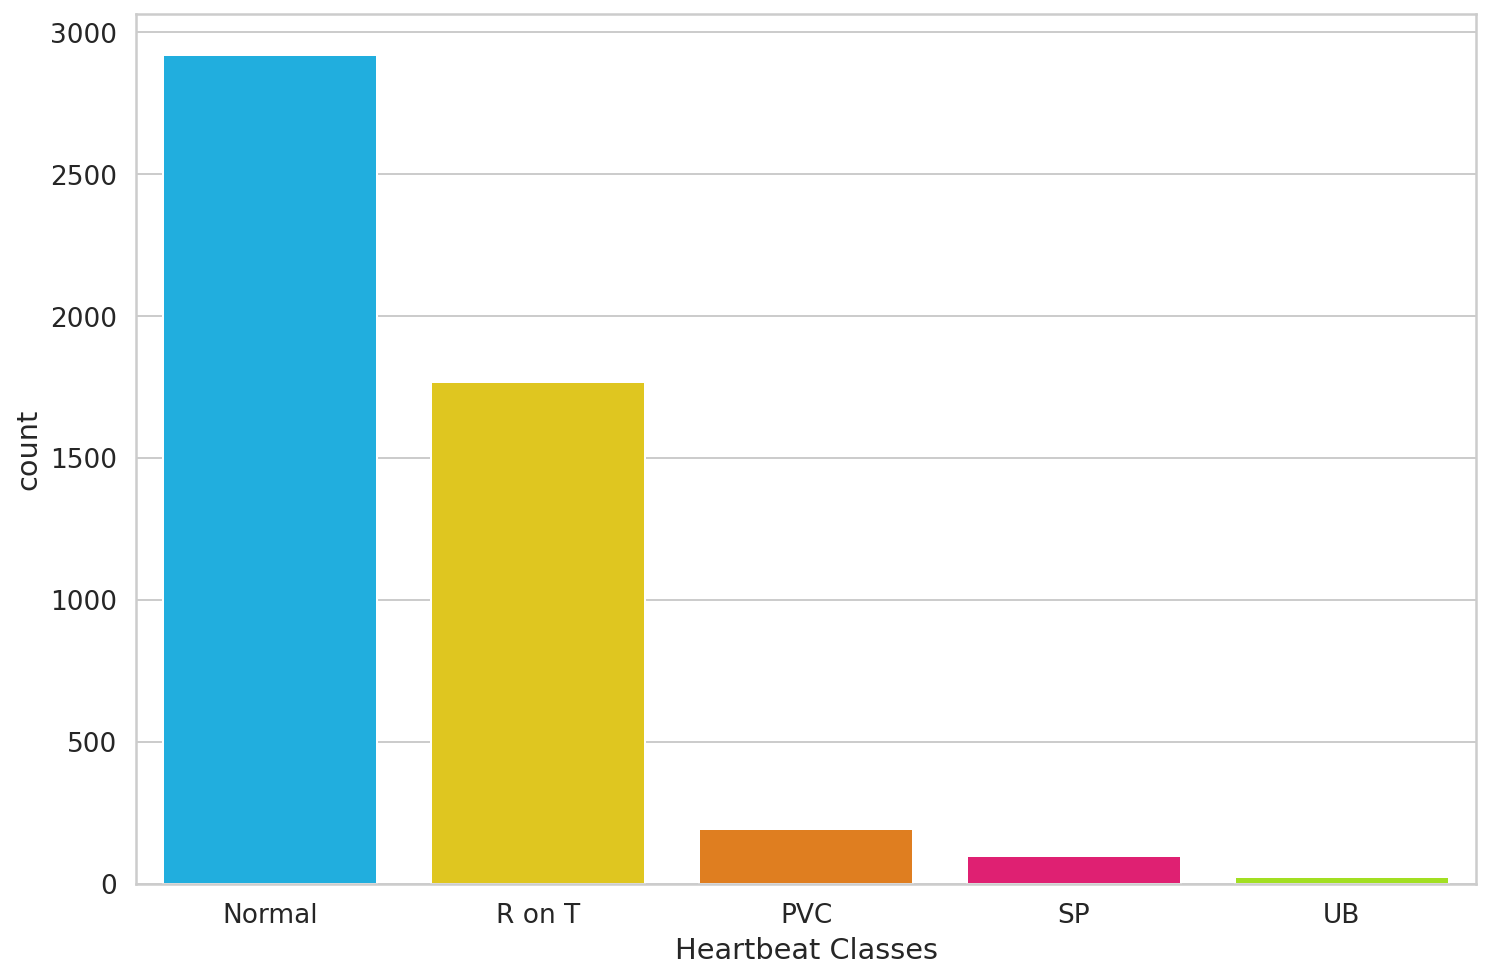

In [ ]:
#plot class results
'''ax = sns.countplot(df.target,)
ax.set_xticklabels(class_names);''' # moved bellow because graph customization was not working




#customise graph:

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

graphcolorpallet = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(graphcolorpallet))

rcParams['figure.figsize'] = 12, 8

# GRAPH CLASS 1 - V1 - IN TESTING NOTEBOOK -
#graph the class data
print("Data Class #1")
ax = sns.countplot(df.target, )
ax.set_xticklabels(class_names);
ax.set(xlabel="Heartbeat Classes",)

#Class 2 of data from my ecg is in the cell bellow






Data Class #2


[Text(0.5, 0, 'Heartbeat Classes')]

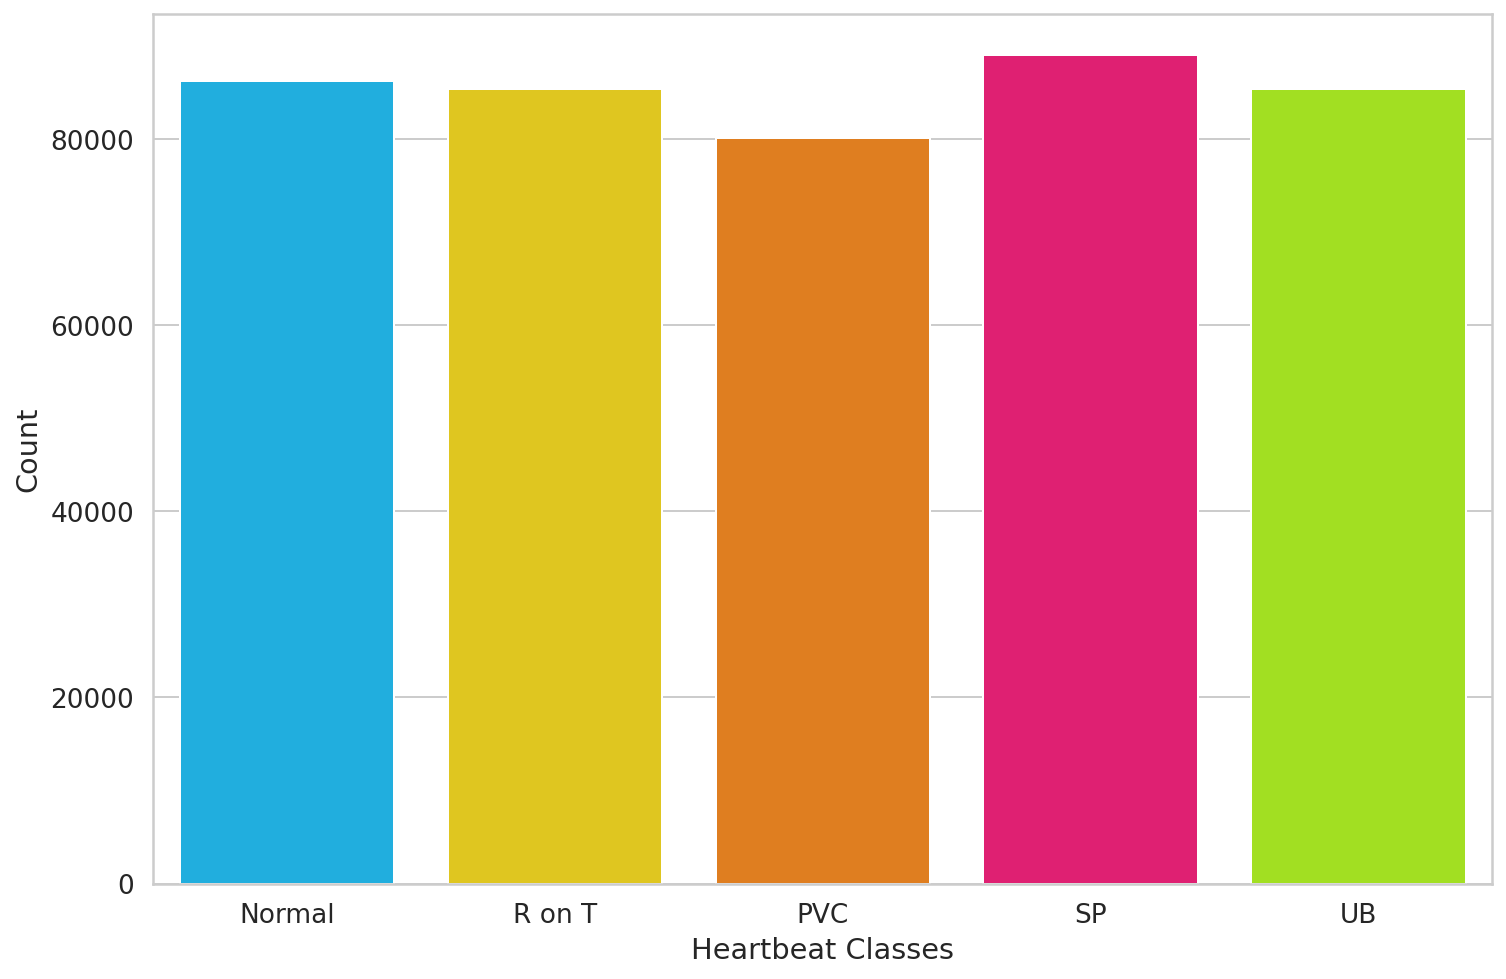

In [ ]:
#Class 2 - Taken from ECG MACHINE - USE CLASS #1 - THIS IS MY TESTING DATA
# FROM OLD COLAB NOTEBOOK

print('Data Class #2')
ax2 = sns.barplot(x=['Normal', 'R on T', 'PVC', 'SP', 'UB'], y=[86285, 85404, 80094, 89000, 85321, ],)
ax2.set_ylabel('Count')
ax2.set(xlabel="Heartbeat Classes",)



In [ ]:
#Function for graphing the standard deviation/time series data for Class #1

def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)





'if fig in dot.range()\nDONT USE BIT SEQUENCING ANYMORE '

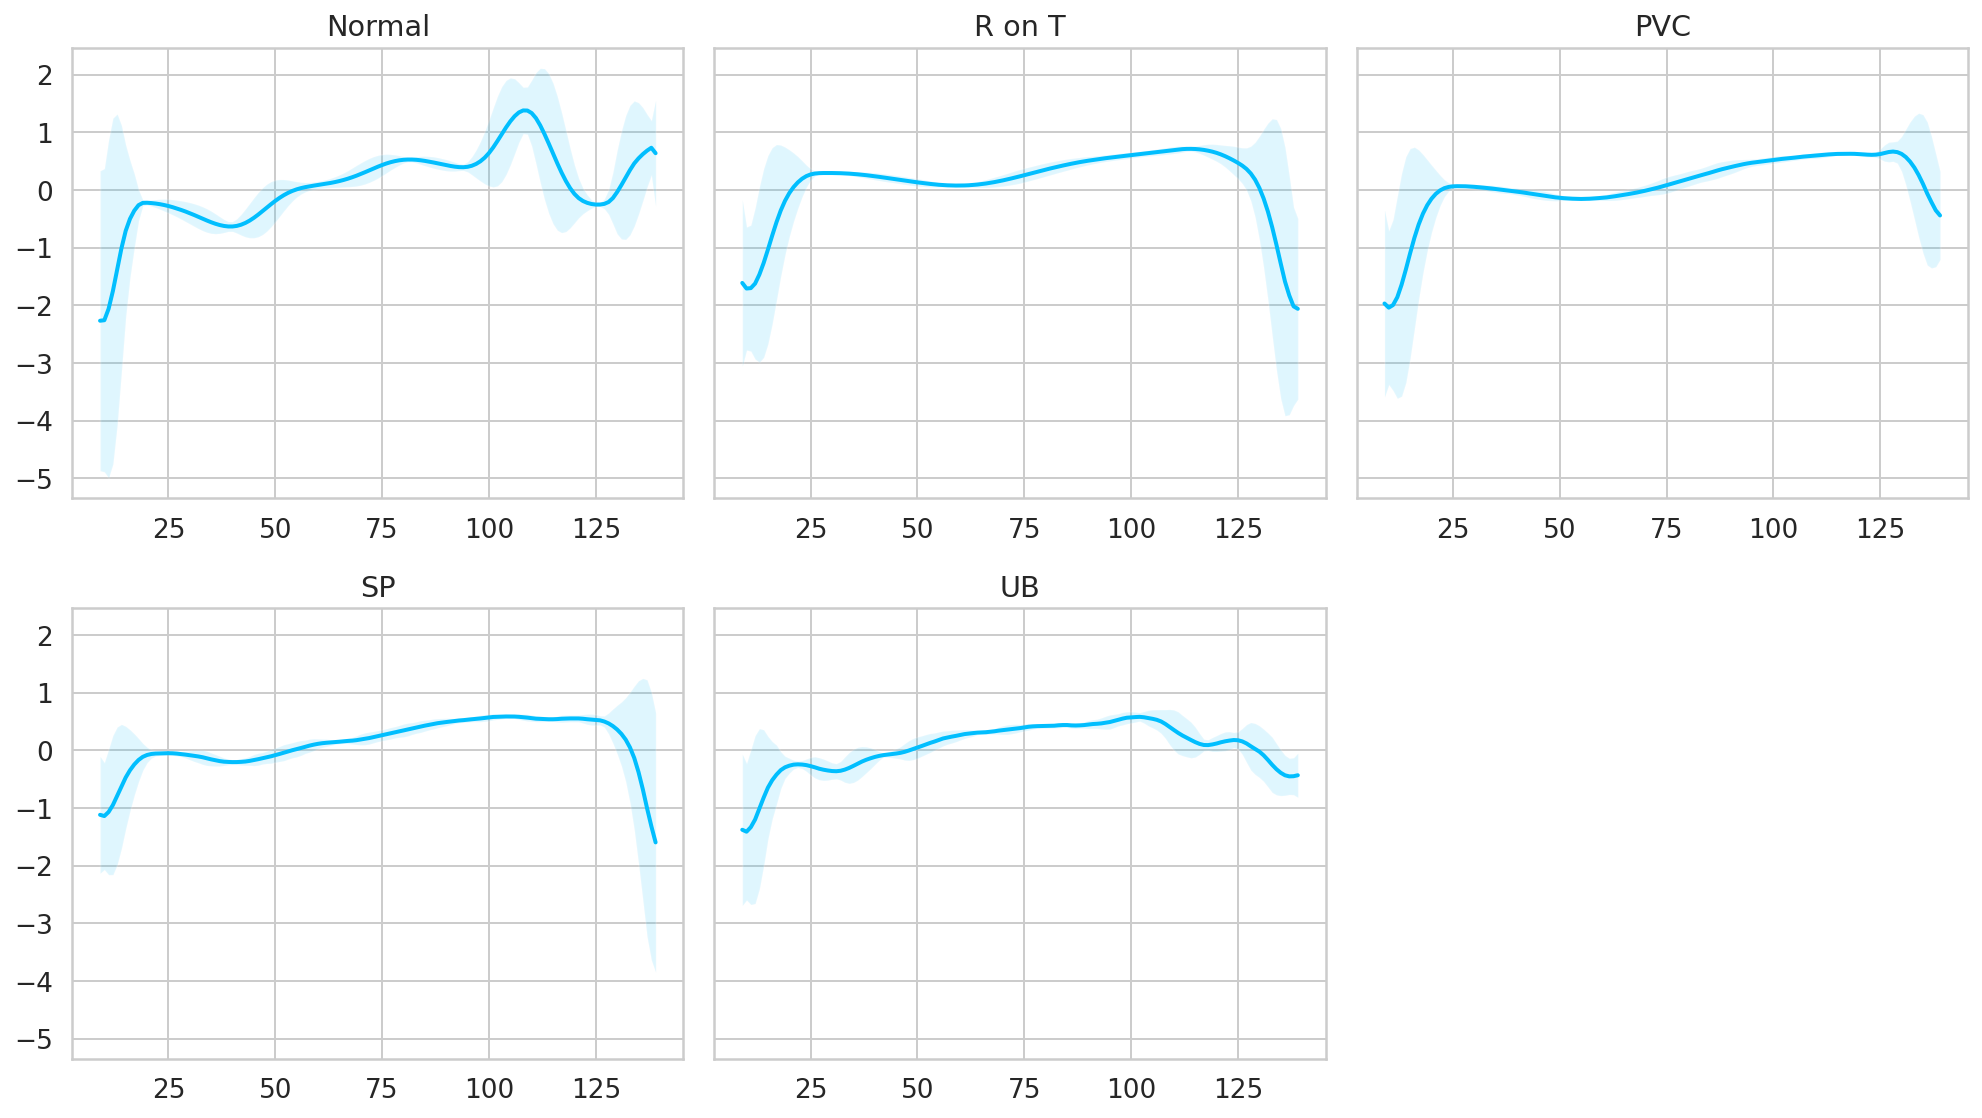

In [ ]:
# call the function to graph out the time series data,  one standard deviation on the top and one standard deviation on the bottom. 

classes = df.target.unique()

fig, axs = plt.subplots( 
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

"""if fig in dot.range()
DONT USE BIT SEQUENCING ANYMORE """

#its good that the program is already detecting a different pattern with normal heartbeats over other classes. 


In [ ]:
# get normal heartbeats from data and delete the target class collum 


normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape




(2919, 140)

In [ ]:
# merge all of the other classes and classify them as anomolies 


anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape








(2081, 140)

In [ ]:
#split data from normal classes into train, validation, and testing data sets 


# first download and import random seed 


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



# then split it into the 3 different classes 

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)



In [ ]:
# convert example dataset into tensors in order to train the autoencoder 

def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features



#the function converts each time series data into a 2d tensor 
# the shape is sequence length x number of features
# so 140x1






In [ ]:
#create some datasets using the function


train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)




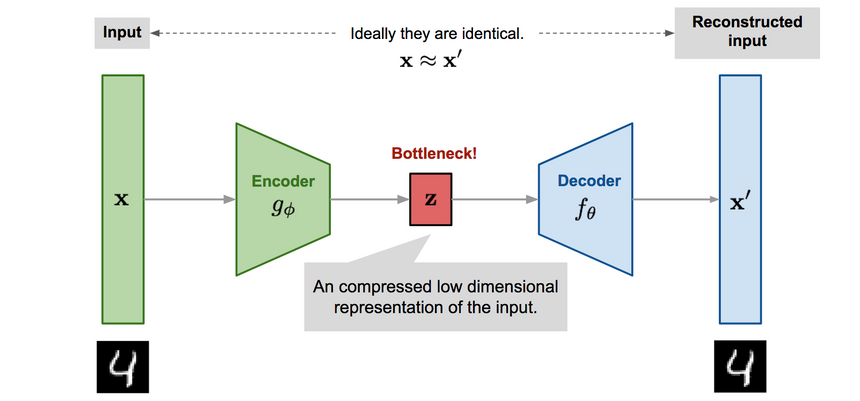


Autoencoder Architecture - contains 2 main compents, the encoder to compress the data and a decoder to reconstruct and analyze it 

In [ ]:
# encoder function


class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True                         
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))




# uses two LSTM layers to compress the Time Series data input
#compressed data is then fed into the decoder


In [ ]:
#  next, the decoder function   decodes the compressed representation of the data 


class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x): 
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)




# decoder contains two LSTM layers and an output layer that gives the final reconstruction.


# The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.



In [ ]:
# wrap up all of the data into a reccurent  autoencoder function


class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


# passes the input through the Encoder and Decoder 

In [ ]:
# create an instance of the autoencoder

model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)


In [ ]:
# helper function for training process 

def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[], val=[])
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0


  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []

    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval()

    with torch.no_grad():

      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)
        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history


# every time the function is run, the training process feeds the model with the training data examples and performs evaluation on the validation data set

# batch size is set to 1 because the model only sees 1 sequence of data at a time 

# function also minimizes the mean absolute error because it functions better with a mean squared error  

In [ ]:
# train model
# 150 epoches takes 27.5 hours - each epoch takes 11 min 


'''import tensorflow as tf
tf.test.gpu_device_name()


model, history = train_model(                          
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)
'''               # instead of that, use pre trained model
                  # this pre trained model is from my kaggle notebook, because it trains faster there



!gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('model.pth',map_location='cpu')
model = model.to(device)





Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
100% 3.98M/3.98M [00:00<00:00, 127MB/s]


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [ ]:
# function for plotting training loss over epoches


'''ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();'''       # done in other kaggle notebook

# graph is down bellow 

"ax = plt.figure().gca()\n\nax.plot(history['train'])\nax.plot(history['val'])\nplt.ylabel('Loss')\nplt.xlabel('Epoch')\nplt.legend(['train', 'test'])\nplt.title('Loss over training epochs')\nplt.show();"

# Training Loss over epoches
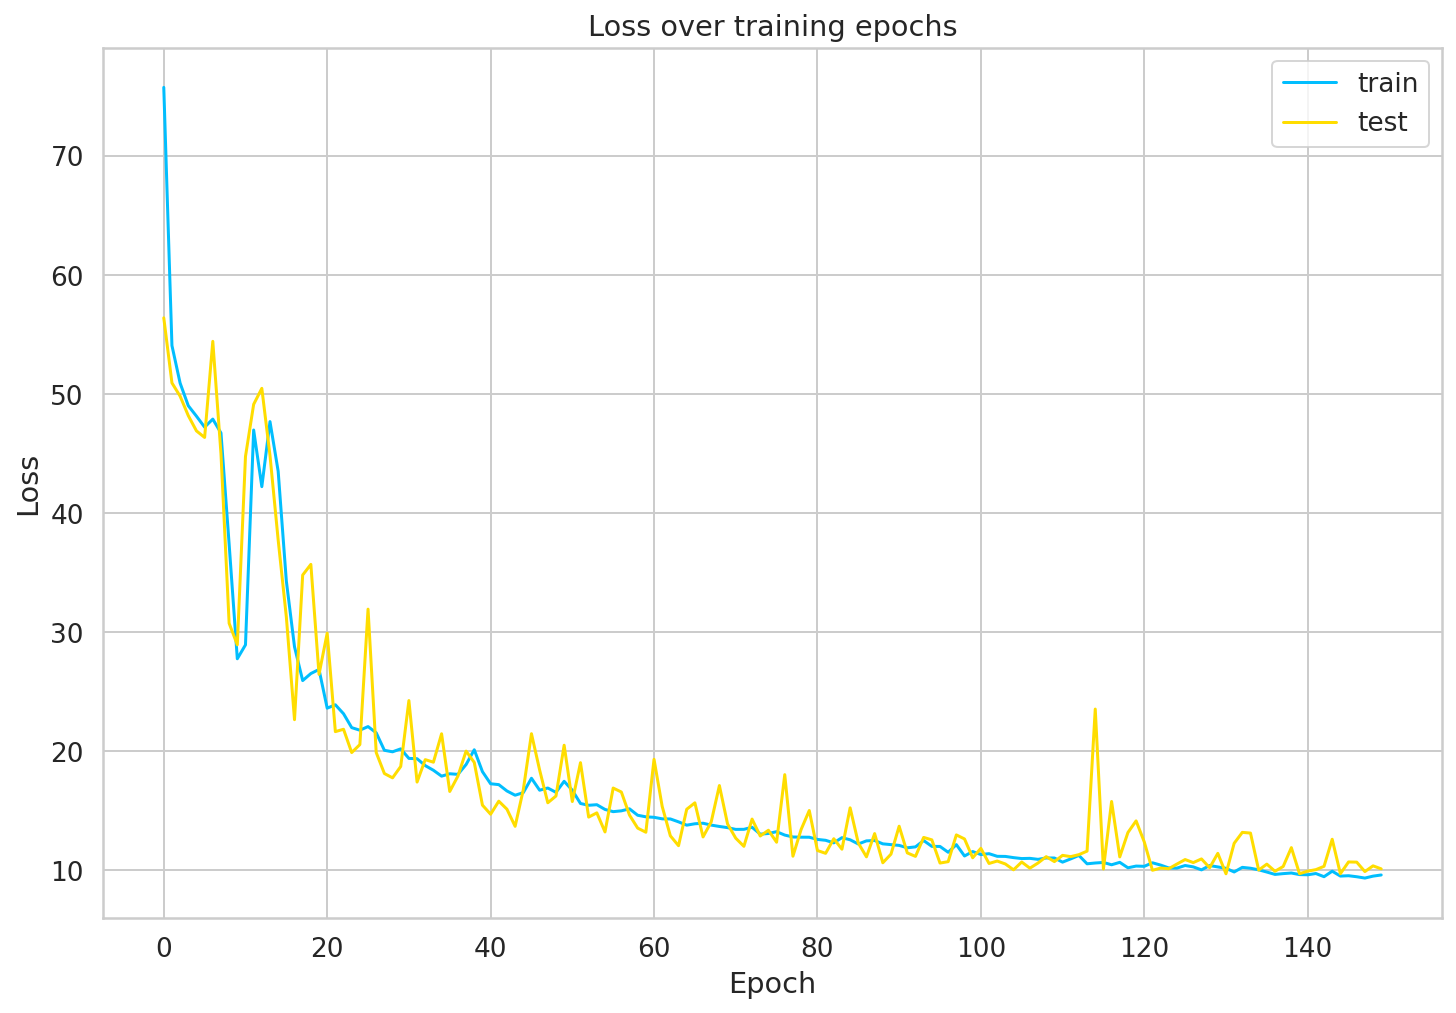

In [ ]:
# helper function to get anomoly predictions from the ecg model

def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses


  # goes through each example in the dataset and records the predictions and losses.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


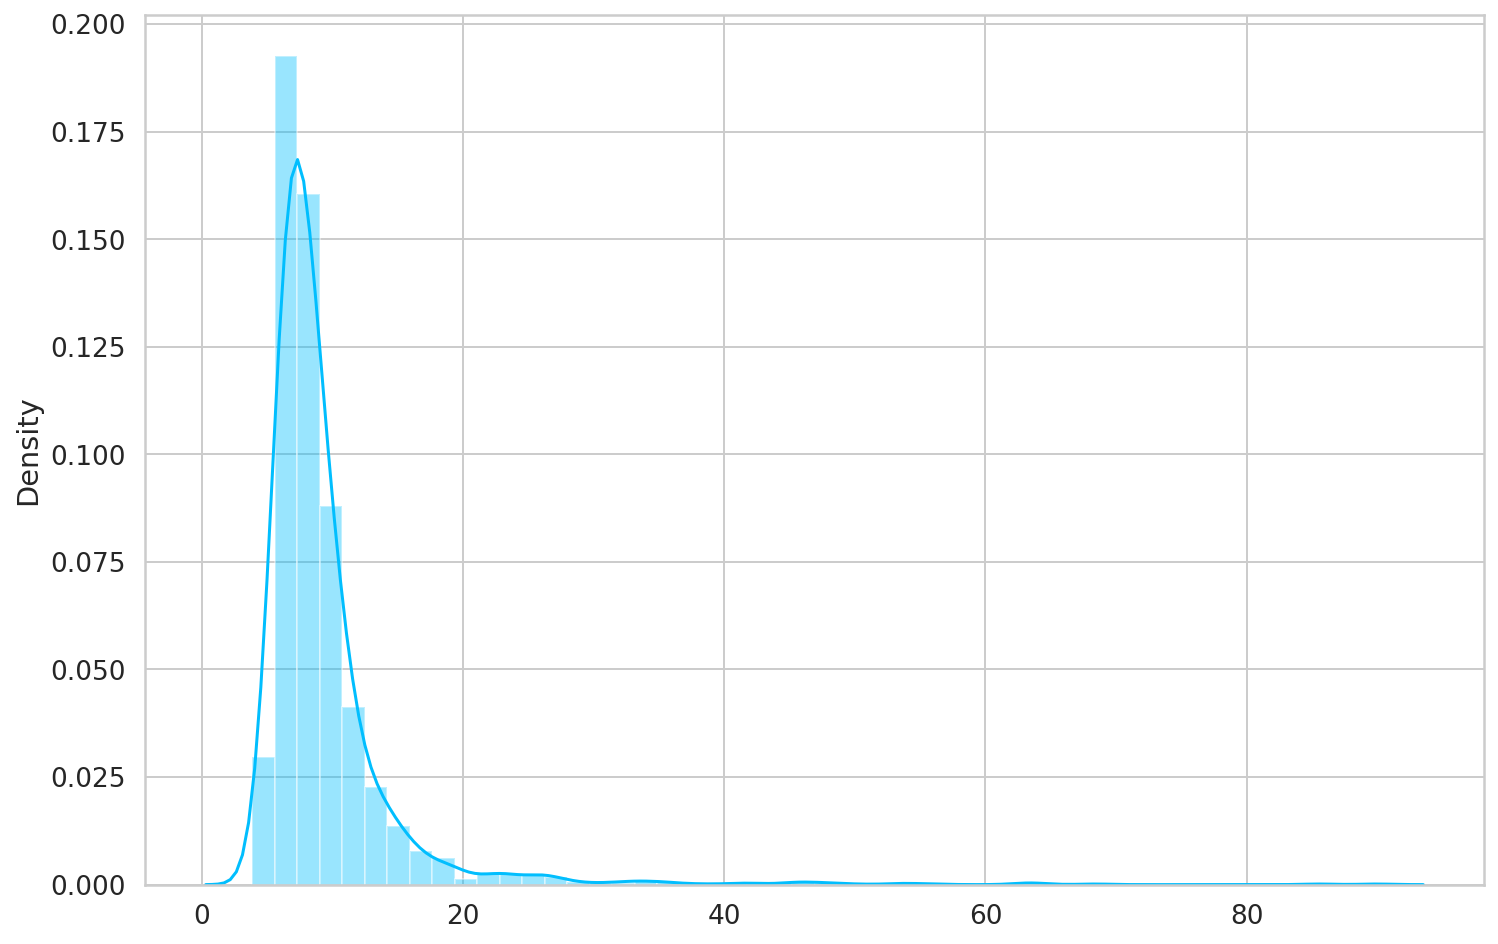

In [ ]:
#go thorught the losses in the dataset examples

_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);



In [ ]:
# using the threashold, the program treats finding Arythmia as a binary classification task

# if the reconstruction loss is bellow the threashold, it is classified as normal and the patient does not have Arythmia 

# if the reconsturction loss is above the threashold, it is classified as an anomoly and the patient has Arythmnia 


THRESHOLD = 26


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


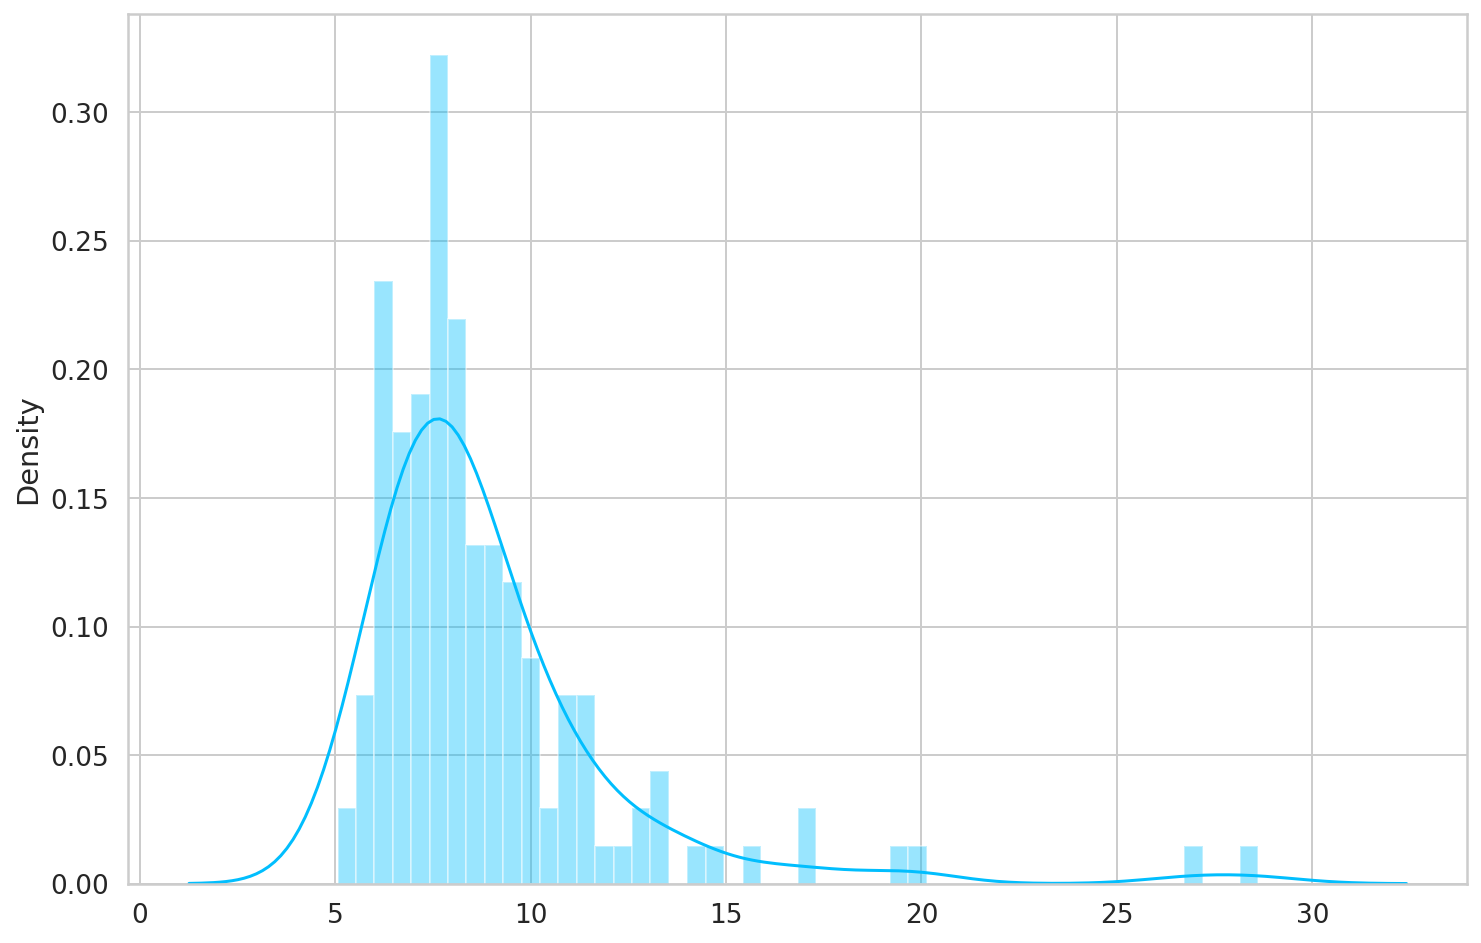

In [ ]:
# see how the model classifies normal heartbeats, this is from the TESTECG500 (model hasnt seen this data yet)

predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);



In [ ]:
# and count the correct predictions for normal heartbeats in the above graph

correct = sum(l <= THRESHOLD for l in pred_losses)



print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

correctPredictions = correct/len(test_normal_dataset) * 100

print(f"Correct normal heartbeat predictions (%): {correctPredictions} %")

Correct normal predictions: 143/145
Correct normal heartbeat predictions (%): 98.62068965517241 %


In [ ]:
# do the same with the arythmia examples, the model will count the correct predictions for Arythmia heartbeats

# also - since there is more anomoly data, set it to the same lenght as the normal dataset (145) 

anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


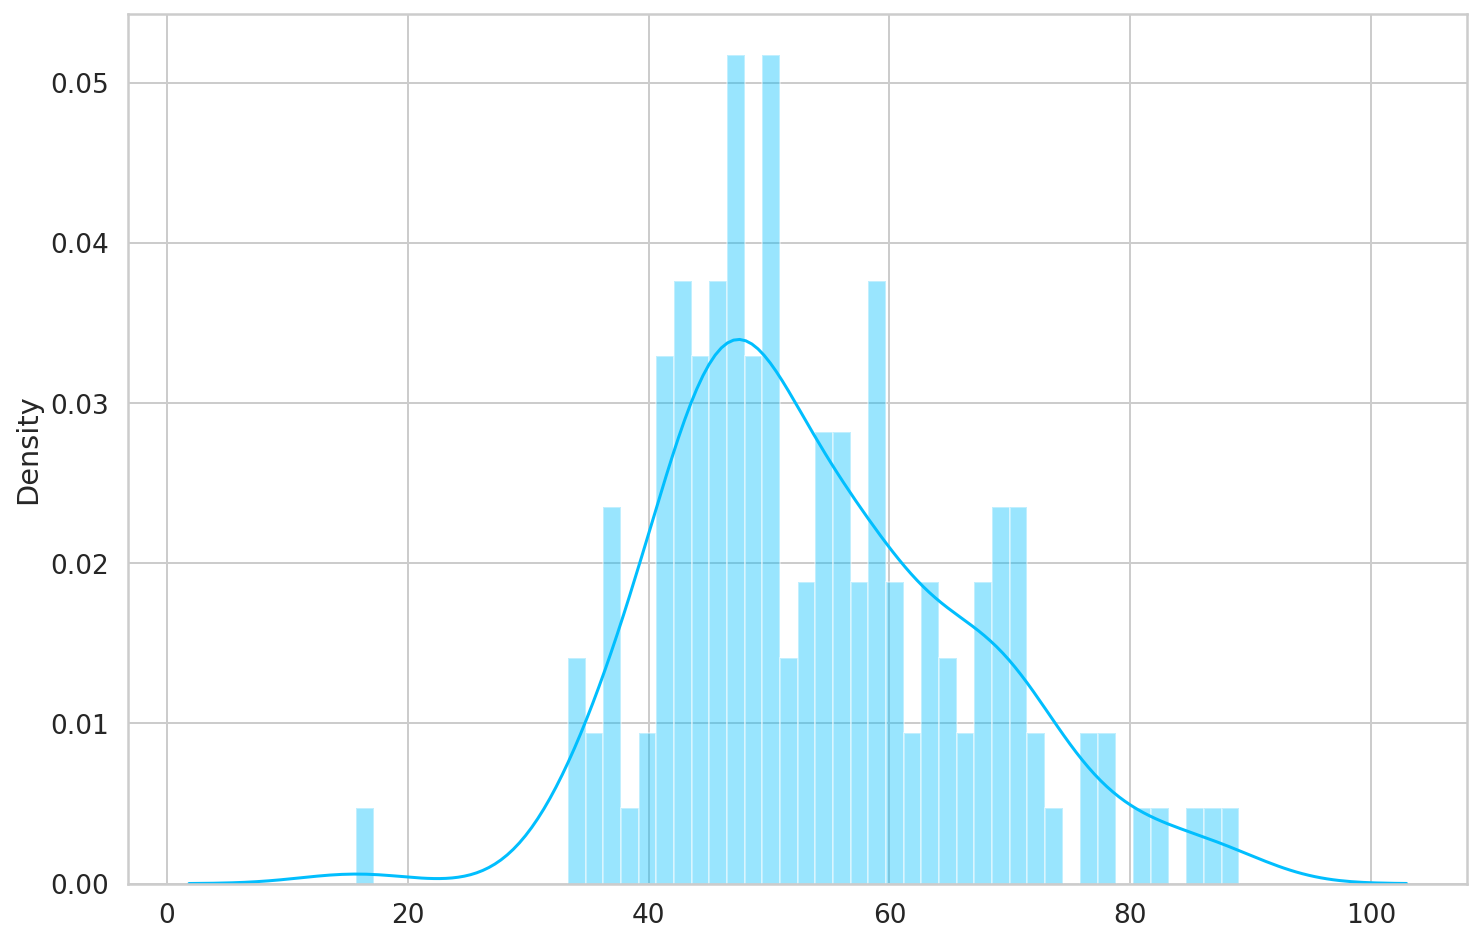

In [ ]:

# graph for how the program detects Arythmia | taken from  TESTECG500 (model hasnt seen this data yet)

predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);


In [ ]:
# finally, count the number of Arythmia heartbeats in the ECG data set

correct = sum(l > THRESHOLD for l in pred_losses)

anomolyPrediction = correct / len(anomaly_dataset) * 100

print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

print(f'Correct Arythmia heartbeat predictions (%): {anomolyPrediction} % ')


Correct anomaly predictions: 144/145
Correct Arythmia heartbeat predictions (%): 99.3103448275862 % 


Algorithm has very good results. you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

In [ ]:
# overlay the real and reconsturcted time series data to see how good the algorithm does in classifying them as anomoly or normal

def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

  

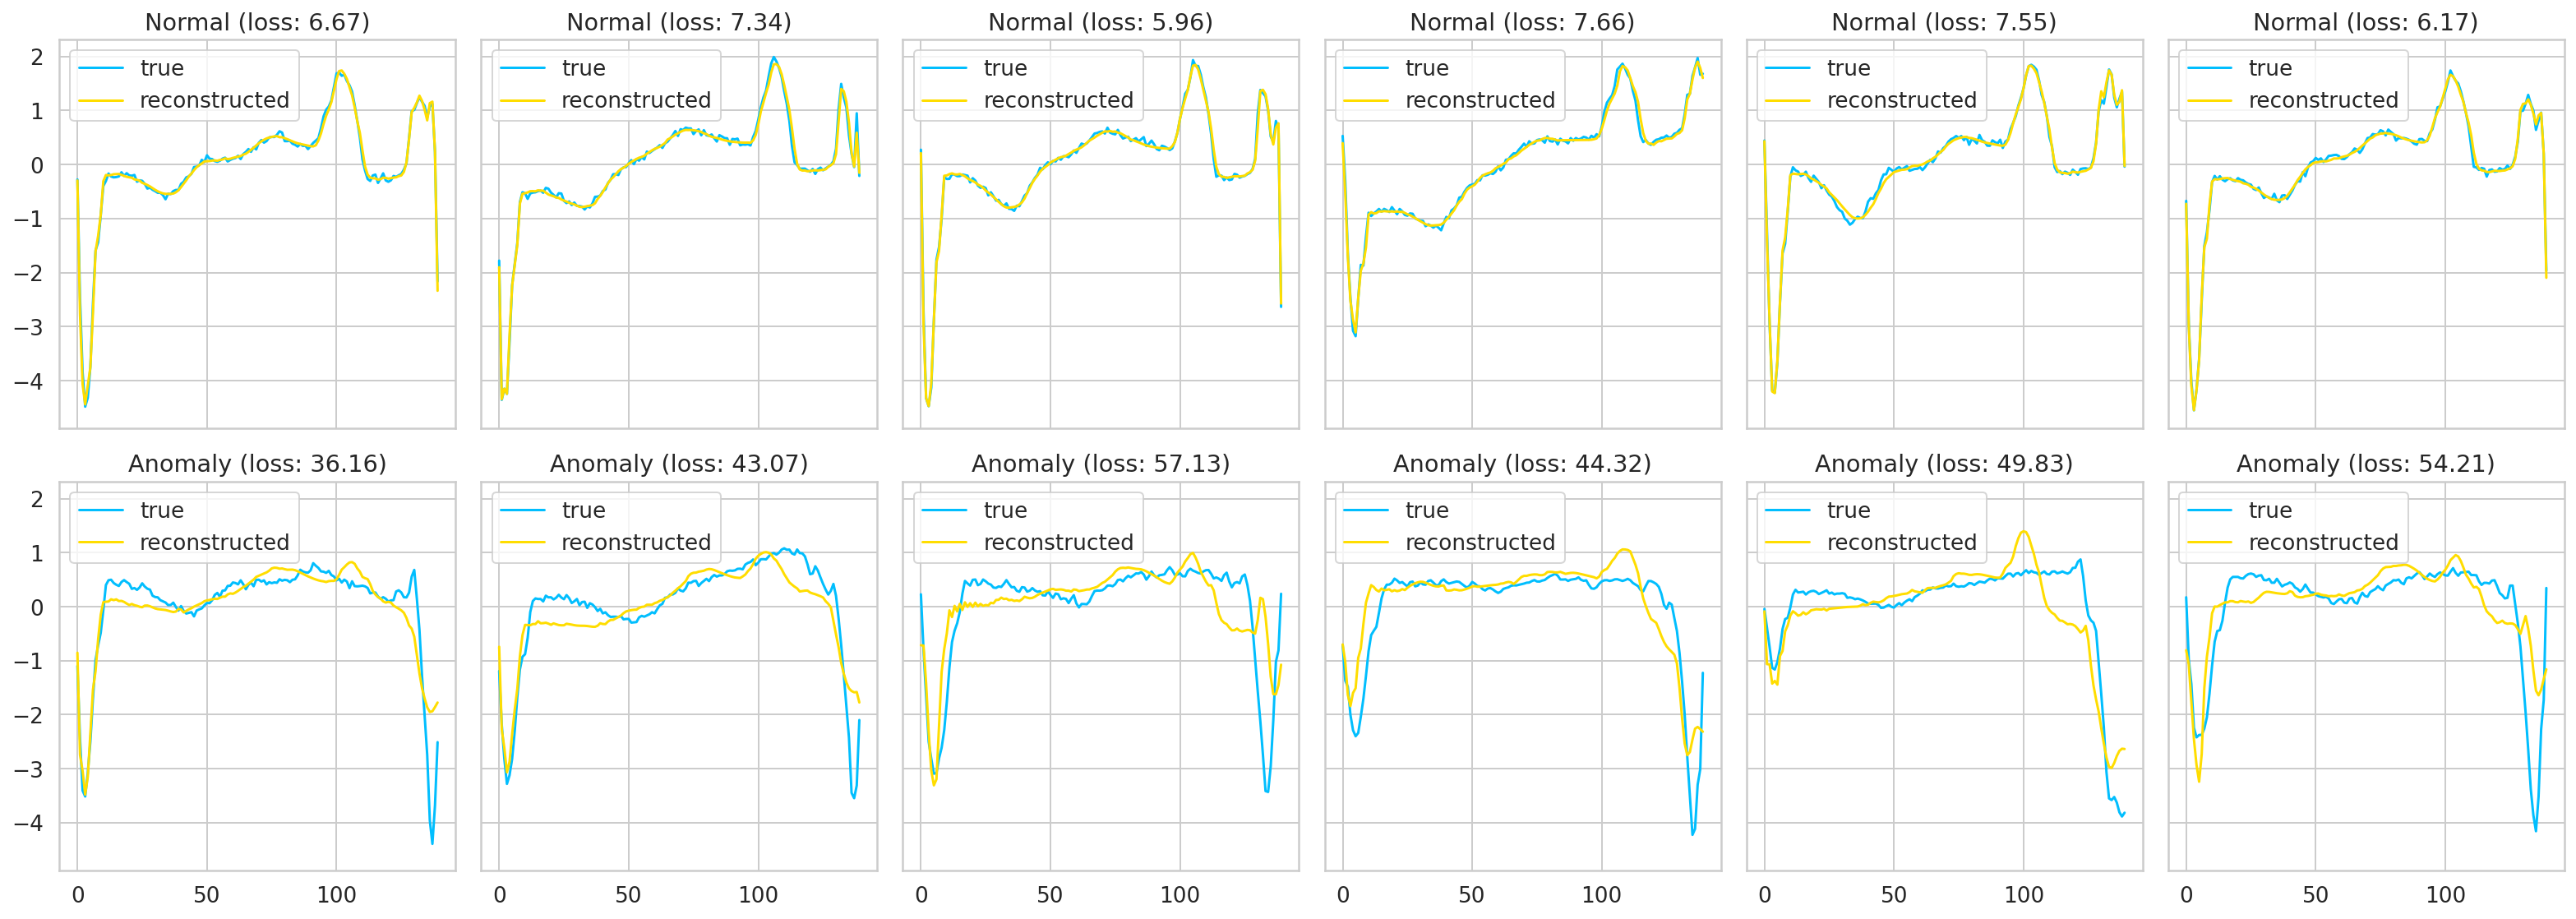

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

Overall, the algorithm works as intended in detecting and clasifying Arythmia in ECG data. 